<a href="https://colab.research.google.com/github/hcoshik98/R_Learning/blob/master/q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install gym[box2d]

In [0]:
!apt-get install python-opengl -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [0]:
!apt install xvfb -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [0]:
!pip3 install pyvirtualdisplay

In [0]:
!pip install piglet

In [0]:
#!pip uninstall pyglet
!pip install --user pyglet==1.3.2

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

W0825 09:22:09.970431 140596758517632 abstractdisplay.py:151] xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1009'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1009'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
import piglet
import pyglet
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1


**OpenAI Gym**

We're gonna spend several next weeks learning algorithms that solve decision processes. We are then in need of some interesting decision problems to test our algorithms.

That's where OpenAI gym comes into play. It's a python library that wraps many classical decision problems including robot control, videogames and board games.

So here's how it works:


Observation space dim: (8,)
Action space shape: 4


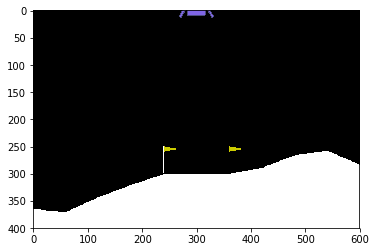

In [0]:
import gym
env = gym.make("LunarLander-v2")

plt.imshow(env.render('rgb_array'))

state_dim=env.observation_space.shape
print("Observation space dim:", state_dim)
n_action= env.action_space.n
print("Action space shape:", n_action)

reset() - reset environment to initial state, return first observation

render() - show current environment state (a more colorful version :) )

step(a) - commit action a and return (new observation, reward, is done, info)


In [0]:
obs0 = env.reset()
print("initial observation code:", obs0)

# Note: in MountainCar, observation is just two numbers: car position and velocity

initial observation code: [ 0.00246687  1.4069852   0.24984276 -0.17488948 -0.00285162 -0.05659312
  0.          0.        ]


In [0]:
print("taking action 2 (right)")
new_obs, reward, is_done, _ = env.step(2)

print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", is_done)

# Note: as you can see, the car has moved to the riht slightly (around 0.0005)
import tensorflow as tf
import keras
import keras.layers as L
tf.reset_default_graph()
sess=tf.InteractiveSession()
keras.backend.set_session(sess)

taking action 2 (right)
new observation code: [ 0.0048296   1.403892    0.23962042 -0.13748403 -0.00616149 -0.06620296
  0.          0.        ]
reward: 2.548833062672924
is game over?: False


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
agent=keras.models.Sequential()
print((2*state_dim[0],))
Layer1=agent.add(L.InputLayer((2*state_dim[0],)))
Layer2=agent.add(L.Dense(100,activation='relu'))
Layer3=agent.add(L.Dense(100,activation='relu'))
Layer4=agent.add(L.Dense(n_action ,activation='softmax'))

agent2=keras.models.Sequential()
Layer12=agent2.add(L.InputLayer((2*state_dim[0],)))
Layer22=agent2.add(L.Dense(100,activation='relu'))
Layer32=agent2.add(L.Dense(100,activation='relu'))
Layer42=agent2.add(L.Dense(n_action ,activation='softmax'))

(16,)


In [0]:
def get_action(s, epsilon):
  q_values=agent.predict(s[None])[0]
  q_values2=agent2.predict(s[None])[0]
  
  expl=np.random.random()
  if expl<epsilon:
    action= np.random.choice(n_action,1)[0]
  else:
    action=np.argmax(q_values + q_values2)
  return action
    

In [0]:
#create placeholder for training
state_ph= tf.placeholder('float32', shape=(None,)+ (2*state_dim[0],))
action_ph= tf.placeholder('int32', shape=[None])
reward_ph= tf.placeholder('float32', shape=[None])
next_st_q= tf.placeholder('float32', shape=[None])
next_st_q2= tf.placeholder('float32', shape=[None])
next_state_ph= tf.placeholder('float32', shape=(None,)+ (2*state_dim[0],))
is_done_ph= tf.placeholder('bool', shape=[None])

In [0]:
pred_q= agent(state_ph)
pred_q2= agent2(state_ph)

pred_qvalues1 = tf.reduce_sum(pred_q*tf.one_hot(action_ph, n_action), axis=1)
pred_qvalues2 = tf.reduce_sum(pred_q2*tf.one_hot(action_ph, n_action), axis=1)

In [0]:
gamma=0.7
#q_values for next state
#next_st_q= agent(next_state_ph)
#next_st_q2= agent2(next_state_ph)
target_q= reward_ph  + gamma*next_st_q#(tf.argmax(next_st_q2))
target_q2= reward_ph + gamma*next_st_q2#(tf.argmax(next_st_q2))

target_q = tf.where(is_done, reward_ph, target_q)
target_q2 = tf.where(is_done, reward_ph, target_q2)

In [0]:
loss1= (tf.stop_gradient(target_q)- pred_qvalues1)**2
loss1= tf.reduce_mean(loss1)
loss2= (tf.stop_gradient(target_q2)- pred_qvalues2)**2
loss2= tf.reduce_mean(loss2)

train_step1= tf.train.AdamOptimizer(1e-4).minimize(loss1)
train_step2= tf.train.AdamOptimizer(1e-4).minimize(loss2)

# Time to play

Try tweaking t or action strategy

**Remember**: Target is to reach to flag

In [0]:
def generate_session(t_max=1000, epsilon=0, train=True):
  import time
  total_reward=0
  s = env.reset()
  see = 0
  pre_st= [0, 0, 0, 0, 0, 0, 0, 0]

  for t in range(t_max):
    pre = np.concatenate((pre_st,s))
    a=get_action(pre, epsilon)
    
    next_s,r,is_done,_ = env.step(a)
    new = np.concatenate((s, next_s))
    q1= agent.predict(new[None])[0]
    q2= agent2.predict(new[None])[0]
    qa1= q1[np.argmax(q2)]
    qa2= q2[np.argmax(q1)]
    
    if train:
      prob=np.random.random()
      if prob<0.8:
        sess.run(train_step1, {state_ph: [pre], action_ph: [a], reward_ph: [r],next_st_q:[qa1],
                               next_st_q2:[qa2], next_state_ph: [new], is_done_ph: [is_done]})
      else:
        sess.run(train_step2, {state_ph: [pre], action_ph: [a], reward_ph: [r],next_st_q:[qa1],
                               next_st_q2:[qa2], next_state_ph: [new], is_done_ph: [is_done]})

    total_reward+=r
    pre_st=s
    s=next_s
    if t%10==0:
      '''fig=plt.imshow(env.render('rgb_array'))
      plt.show(fig)
      time.sleep(0.01)
      plt.close('all')'''
    
    #plt.imshow(env.render('rgb_array'))
    if is_done:
      
      see+=1
      break
  

  return total_reward

In [0]:
epsilon=0.5

In [0]:

for i in range(600):
  session_rewards= [generate_session(epsilon=epsilon, train=True) for _ in range(10)]
  print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards),
                                                                   epsilon))

  #plt.imshow(env.render('rgb_array'))
  epsilon*=0.99
  assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
  if np.mean(session_rewards) < -100 and epsilon < 0.01:
      epsilon = 0.3
    
  if np.mean(session_rewards) > 10:
      print ("You Win!")
      break

epoch #0	mean reward = -250.724	epsilon = 0.500
epoch #1	mean reward = -101.817	epsilon = 0.495
epoch #2	mean reward = -169.213	epsilon = 0.490
epoch #3	mean reward = -230.688	epsilon = 0.485
epoch #4	mean reward = -132.603	epsilon = 0.480
epoch #5	mean reward = -152.021	epsilon = 0.475
epoch #6	mean reward = -209.672	epsilon = 0.471
epoch #7	mean reward = -111.895	epsilon = 0.466
epoch #8	mean reward = -129.971	epsilon = 0.461
epoch #9	mean reward = -161.959	epsilon = 0.457
epoch #10	mean reward = -132.255	epsilon = 0.452
epoch #11	mean reward = -122.230	epsilon = 0.448
epoch #12	mean reward = -144.843	epsilon = 0.443
epoch #13	mean reward = -124.031	epsilon = 0.439
epoch #14	mean reward = -140.924	epsilon = 0.434
epoch #15	mean reward = -119.026	epsilon = 0.430
epoch #16	mean reward = -162.341	epsilon = 0.426
epoch #17	mean reward = -145.205	epsilon = 0.421
epoch #18	mean reward = -101.655	epsilon = 0.417
epoch #19	mean reward = -145.617	epsilon = 0.413
epoch #20	mean reward = -169.1

In [0]:
import glob, io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [0]:
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("LunarLander-v2"),directory="videos",force=True)
sessions = [generate_session(epsilon=0, train=False) for _ in range(1000)]
env.close()


def show_video():
  mp4list = glob.glob('videos/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

ModuleNotFoundError: ignored

In [0]:
show_video()

In [0]:
from google.colab import files
mp4list = glob.glob('videos/*.mp4')
mp4 = str(mp4list[0])
files.download(mp4)

videos/openaigym.video.13.825.video000216.mp4
